# MyBinder Analytics Data Analysis

+++ {"class": "col-page"}

This notebook analyzes MyBinder launch data from the automated releases at the following URL:

[github.com/jupyterhub/binder-data/releases/tag/latest](https://github.com/jupyterhub/binder-data/releases/tag/latest)

In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [9]:
def load_binder_data(
    url="https://github.com/jupyterhub/binder-data/releases/download/latest/launches.parquet",
):
    """
    Load MyBinder analytics data from GitHub release.

    Args:
        url: URL to the parquet file in GitHub releases

    Returns:
        DataFrame with binder launch data
    """
    print(f"Loading data from: {url}")

    try:
        df = pd.read_parquet(url)
        print(f"✓ Loaded {len(df):,} records")
        print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        df["timestamp"] = pd.to_datetime(df["timestamp"])    
        return df
    except Exception as e:
        print(f"✗ Failed to load data: {e}")
        raise  # Re-raise the exception to fail the notebook"

In [10]:
# Load the data
df = load_binder_data()
df.head()

Loading data from: https://github.com/jupyterhub/binder-data/releases/download/latest/launches.parquet
✓ Loaded 4,239,105 records
Date range: 2023-08-21 00:00:00+00:00 to 2025-08-20 19:06:00+00:00


,origin,provider,spec,timestamp
0,notebooks.gesis.org,GitHub,ipython/ipython-in-depth/HEAD,2023-08-21 00:00:00+00:00
1,notebooks.gesis.org,GitHub,biosustain/cameo-notebooks/master,2023-08-21 00:00:00+00:00
2,notebooks.gesis.org,GitHub,matplotlib/mpl-brochure-binder/main,2023-08-21 00:00:00+00:00
3,notebooks.gesis.org,GitHub,brian-team/brian2-binder/master,2023-08-21 00:01:00+00:00
4,notebooks.gesis.org,GitHub,brian-team/brian2-binder/master,2023-08-21 00:02:00+00:00


## Launches Over Time by Source

Weekly trends of Binder launches grouped by the BinderHub that launched them.

In [5]:
def plot_launches_by_source_over_time(df):
    """
    Create interactive stacked area chart showing number of launches over time by week for each source.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "origin" not in df.columns:
        print("Missing required columns for time series analysis")
        return

    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    df_filtered = df[df["timestamp"] < latest_week_start]
    
    # Resample by week and count launches by origin
    df_weekly = (
        df_filtered.set_index("timestamp").groupby("origin").resample("W", include_groups=False).size().reset_index()
    )
    df_weekly.columns = ["origin", "week", "launches"]

    # Get top sources for better visualization
    top_sources = df_filtered["origin"].value_counts().head(8).index
    df_weekly_top = df_weekly[df_weekly["origin"].isin(top_sources)]

    fig = px.area(
        df_weekly_top, 
        x="week", 
        y="launches", 
        color="origin",
        title="MyBinder Launches Over Time by Source (Weekly - Stacked)",
        labels={"week": "Date", "launches": "Number of Launches", "origin": "Source"}
    )
    
    fig.update_layout(
        width=1000, 
        height=600,
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    fig.show()

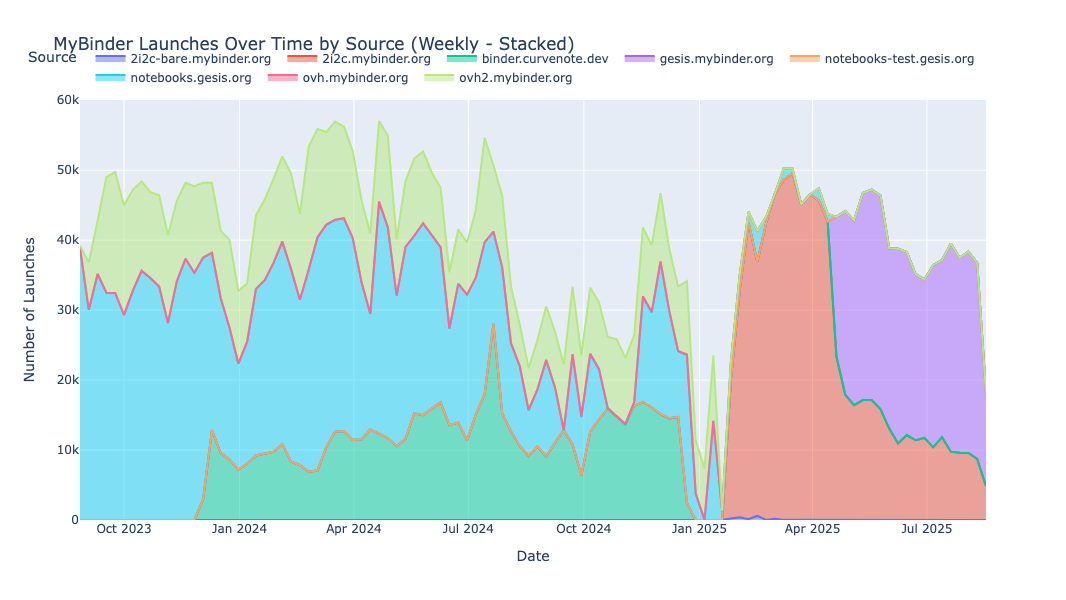

In [6]:
plot_launches_by_source_over_time(df)

## Top 25 Repositories (Last 90 Days)

The most popular repositories launched on MyBinder in the last 90 days.

In [ ]:
def plot_top_repositories_last_90_days(df):
    """
    Create interactive horizontal bar chart of launches in the last 90 days for top 25 repositories.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "spec" not in df.columns:
        print("Missing required columns for repository analysis")
        return

    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    
    # Filter to last 90 days (excluding latest week)
    cutoff_date = latest_week_start - timedelta(days=90)
    df_recent = df[(df["timestamp"] >= cutoff_date) & (df["timestamp"] < latest_week_start)]

    # Count launches by repository (spec)
    repo_counts = df_recent["spec"].value_counts().head(25)
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'repository': repo_counts.index,
        'launches': repo_counts.values
    })
    
    fig = px.bar(
        plot_df,
        x="launches",
        y="repository",
        orientation="h",
        title="Top 25 Repositories by Launches (Last 90 Days, excluding latest week)",
        labels={"launches": "Number of Launches", "repository": "Repository"},
        text="launches"
    )
    
    fig.update_layout(
        width=1000,
        height=800,
        yaxis={'categoryorder': 'total ascending'}
    )
    
    fig.update_traces(textposition='outside')
    
    fig.show()

In [ ]:
plot_top_repositories_last_90_days(df)

## Provider Distribution (Last 90 Days)

Distribution of launches by git provider (GitHub, GitLab, etc.) in the last 90 days.

In [ ]:
def plot_provider_distribution_last_90_days(df):
    """
    Create bar chart showing distribution of launches by provider in the last 90 days.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "provider" not in df.columns:
        print("Missing required columns for provider analysis")
        return

    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    
    # Filter to last 90 days (excluding latest week)
    cutoff_date = latest_week_start - timedelta(days=90)
    df_recent = df[(df["timestamp"] >= cutoff_date) & (df["timestamp"] < latest_week_start)]

    # Count launches by provider
    provider_counts = df_recent["provider"].value_counts()
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'provider': provider_counts.index,
        'launches': provider_counts.values
    })
    
    fig = px.bar(
        plot_df,
        x="provider",
        y="launches",
        title="MyBinder Launches by Provider (Last 90 Days, excluding latest week)",
        labels={"launches": "Number of Launches", "provider": "Provider"},
        text="launches"
    )
    
    fig.update_layout(
        width=800,
        height=600,
        xaxis={'categoryorder': 'total descending'}
    )
    
    fig.update_traces(textposition='outside')
    
    fig.show()

In [ ]:
plot_provider_distribution_last_90_days(df)

## Summary Statistics

Key metrics about the MyBinder analytics dataset:

In [ ]:
# Additional summary statistics
if not df.empty:
    print("Summary Statistics:")
    print("=" * 50)

    total_launches = len(df)
    print(f"Total launches: {total_launches:,}")

    if "origin" in df.columns:
        unique_sources = df["origin"].nunique()
        print(f"Unique sources: {unique_sources}")

    if "spec" in df.columns:
        unique_repos = df["spec"].nunique()
        print(f"Unique repositories: {unique_repos:,}")

    if "timestamp" in df.columns:
        date_range = (df["timestamp"].max() - df["timestamp"].min()).days
        print(f"Data spans: {date_range} days")
        avg_launches_per_day = total_launches / date_range if date_range > 0 else 0
        print(f"Average launches per day: {avg_launches_per_day:.1f}")

    # Recent activity (last 30 days)
    if "timestamp" in df.columns:
        recent_cutoff = df["timestamp"].max() - timedelta(days=30)
        recent_launches = len(df[df["timestamp"] >= recent_cutoff])
        print(f"Launches in last 30 days: {recent_launches:,}")